# Particle injection from wall

Particle injection from wall is not yet implemented in the code C code. This notebook illustrates implementing particle injection from wall using Python.

We start by creating particle species without any initial particle distribution:

In [1]:
import sys  
sys.path.insert(0, '../source')
import em1d as zpic

import numpy as np

nx = 128
box = 12.8
dt = 0.09
ppc = 5

# Create 2 particle species with no initial particles
electrons = zpic.Species( "electrons", -1.0, ppc, density = zpic.Density( type = "empty" ) )
positrons = zpic.Species( "positrons", +1.0, ppc, density = zpic.Density( type = "empty" ) )

# Initialize the simulation without diagnostics
sim = zpic.Simulation( nx, box, dt, species = [electrons,positrons] )

The following function will inject particles from the left wall using a generalized velocity $u_{fl}$. For simplicity, this function requires that we keep the position of the next particle to be injected (a "stateless" version could also be implemented).

In [2]:
def inject( species, ufl, pos ):
    vfl = ufl / np.sqrt( ufl**2 + 1 )
    pos = pos + vfl * species.dt / species.dx

    u = np.array([ufl,0.0,0.0], dtype = np.float32 )
        
    while( pos >= 0 ):
        # Particles are always added to 1st cell (0)
        species.add( 0, pos, u )
        pos = pos - ( 1.0 / species.ppc )
    
    return pos

ZPIC is then run with a special loop (instead of just calling the `run()` method) so we can inject particles at each timestep:

In [3]:
# Total number of iterations
tmax = 1.0
niter = tmax / dt
niter = 8
ufl = 1e9

# Position of the next particle to be injected
# (position is normalized to cell size)
pos_ele = - 0.5 / electrons.ppc
pos_pos = - 0.5 / positrons.ppc

while ( sim.n < niter ):
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    sim.iter()
    pos_ele = inject( electrons, ufl, pos_ele )
    pos_pos = inject( positrons, ufl, pos_pos )

The phasespace shows the injected particles

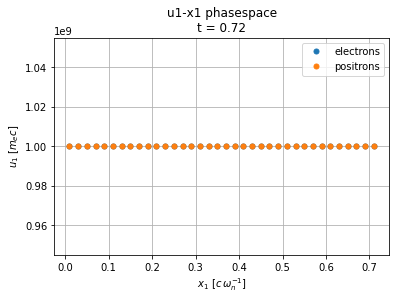

In [4]:
import matplotlib.pyplot as plt

# Simple function to convert particle positions
x = lambda s : (s.particles['ix'] + s.particles['x']) * s.dx 

plt.plot(x(electrons), electrons.particles['ux'], '.', ms=10, label = "electrons")
plt.plot(x(positrons), positrons.particles['ux'], '.', ms=10, label = "positrons")
plt.xlabel("$x_1$ [$c\,\omega_n^{-1}$]")
plt.ylabel("$u_1$ [$m_e c$]")
plt.title("u1-x1 phasespace\nt = {:g}".format(sim.t))
plt.legend()
plt.grid(True)
plt.show()